1) Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

2) *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

3) *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.(реализованно в 4 блоке)

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30)

In [4]:
def gb_predict(X, trees_list, eta):  
# Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
# поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
# прибавляются с шагом eta
    # Было:
#     predictions = np.array(
#         [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
#     )

    # Теперь:
    predictions = np.array(sum([eta * alg.predict(X) for alg in trees_list]))

    return predictions

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def residual(y, z):
    return - (z - y)#Используем  𝐿2: 𝐿(𝑦,𝑧)=(𝑦−𝑧)2,ее производная по  𝑧 будет 𝐿′(𝑦,𝑧)=2(𝑧−𝑦), 2 мы можем не брать 

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

**1) Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.**

Посмотрим зависимость ошибки от количества деревьев в ансамбле, при этом постоянно изменяя глубину.

In [17]:
eta = 1
n_trees = range(1, 27)


def visualization_different_num_trees(n_trees=n_trees, max_depth=3):
    train_errors_trees = []
    test_errors_trees = []

    for n in tqdm(n_trees):
        trees, train_errors, test_errors = gb_fit(n, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_trees.append(train_errors[-1])
        test_errors_trees.append(test_errors[-1])


    print(f'Максимальная глубина дерева {max_depth}')
    plt.plot(n_trees, train_errors_trees, label='train_error')
    plt.plot(n_trees, test_errors_trees, label='test_error')
    plt.xlabel('Количество алгоритмов в бустинге')
    plt.ylabel('MSE')
    plt.xticks(n_trees, n_trees)
    plt.legend()

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 31.48it/s]

Максимальная глубина дерева 3


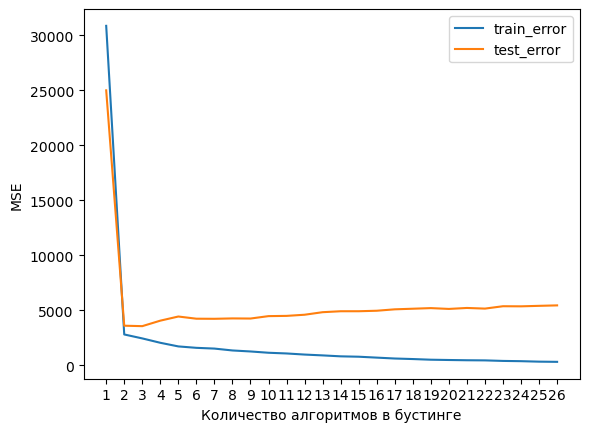

In [18]:
visualization_different_num_trees(n_trees=n_trees, max_depth=3)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 23.83it/s]

Максимальная глубина дерева 7


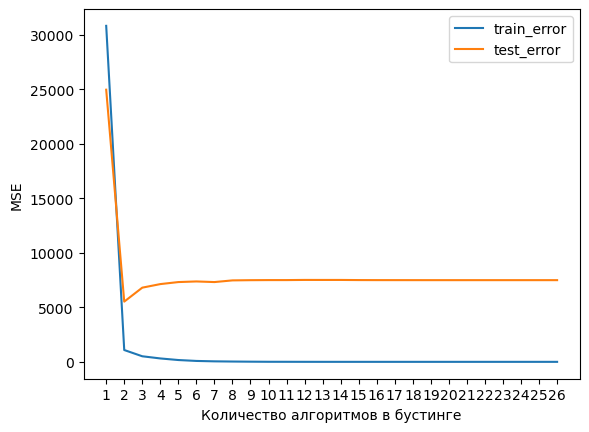

In [19]:
visualization_different_num_trees(n_trees=n_trees, max_depth=7)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.05it/s]


Максимальная глубина дерева 12


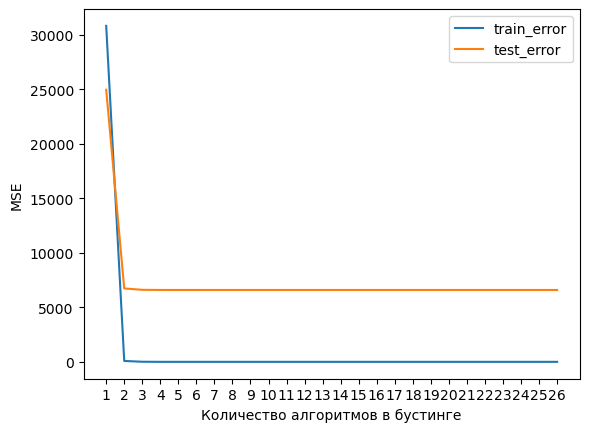

In [20]:
visualization_different_num_trees(n_trees=n_trees, max_depth=12)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 36.79it/s]


Максимальная глубина дерева 1


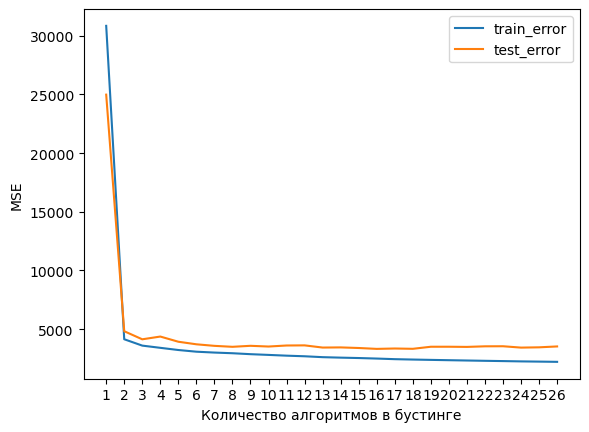

In [21]:
visualization_different_num_trees(n_trees=n_trees, max_depth=1)

Мы видим, что во всех вариантах на первом дереве идет сильное и резкое уменьшение ошибки, потом ситуация становится разной в зависимости от глубины деревьев.


При глубине равной 3 мы видим, что с 3 го дерева трейн продолжает плавно снижаться, а вот тест напротив растет, что может говорить нам о переобучении.


Если мы ставим глубину дерева равную 7, то можем наблюдать, что до 2го дерева шло уменьшение ошибки и у трейна и у теста(не пропорционально, тест показывает более высокую ошибку), а вот на 3м дереве у трейна продолжилось снижение ошибки вплоть до 5го дерева, а вот тест показал скачковое увеличение ошибки. При этом с пятого дерева и трейн и тест не показывают значимых изменений ошибки, идя ровно и параллельно.


При глубине в 12, мы видим примерно тоже самое, что и при глубине в 7.


Наглядно видно, что увеличение глубины, только портит показатели.
Пробуя глубину равную 1, мы видим наилучший результат из представленных. И трейн , и тест показывают систематическое снижение ошибки вплоть до 8 дерева, с не таким значительным разрывом между собой как мы наблюдали ранее. С 8 дерева ошибка на тестовых данных начала постепенно увеличиваться , модель могла начать переучиваться.


На мой взгляд оптимальными в этих условиях будут параметры: глубина дерева равная 1, и ансамбль из 8 деревьев .